In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [5]:
#load the data

def parse_input(x):
    try: 
        return float(x)
    except:
        return 0.

f = open('../arrhythmia/arrhythmia.data','r')
data = []
l = f.readline().strip().split(',')
while len(l) > 2:
    l = [parse_input(ll) for ll in l]
    l = np.array(l)
    data.append(l)
    l = f.readline().strip().split(',')
    
data = np.vstack(data)
X = data[:,:-1]
y = data[:,-1]


m,n = np.shape(X)
m_train = int(np.ceil(.6*m))
m_test = m - m_train

#split the data
np.random.seed(0)
idx_train = np.random.permutation(m)[:m_train]
idx_test = [i for i in range(m) if i not in idx_train]


sio.savemat('../arrhythmia/arrhythmia.mat',{'X':X,'y':y,'idx_train':idx_train, 'idx_test':idx_test})


In [8]:

data = sio.loadmat('../arrhythmia/arrhythmia.mat')
X,y = data['X'], data['y'][0,:]
y[np.not_equal(y,1)] = -1

print(sum(np.equal(y,1)))
print(sum(np.equal(y,-1)))
idx_train = data['idx_train'][0,:]
idx_test = data['idx_test'][0,:]

m,n = np.shape(X)
m_train = len(idx_train)
m_test = len(idx_test)

Xtrain = X[idx_train,:]
ytrain = y[idx_train]

Xtest = X[idx_test,:]
ytest = y[idx_test]

#normalize the data

Xmean = np.mean(Xtrain,axis=0)
Xtrain = Xtrain - np.outer(np.ones(m_train), Xmean)
Xtest = Xtest - np.outer(np.ones(m_test), Xmean)


Xvar = np.std(Xtrain, axis=0)
Xtrain = Xtrain / (np.outer(np.ones(m_train), Xvar)+1.)
Xtest = Xtest /(np.outer(np.ones(m_test), Xvar) + 1.)


def get_misclassify(y,y_est):
    misclassify = np.sum(np.not_equal(np.sign(y_est),y))/(len(y)+0.)
    return misclassify



245
207


In [13]:

def get_proj_operator(Z):
    mt,n = Z.shape
    A = np.hstack([Z,-np.eye(mt)])
    AA = np.dot(Z,Z.T) + np.eye(mt)
    
    M = np.linalg.solve(AA, A)
    M = M.T
    
    def proj_soln(theta,s):
        z0 = np.hstack([theta,s])
        b = np.ones(mt) - np.dot(A,z0)
        z = np.dot(M, b) + z0
        theta = z[:n]
        s = z[n:]
        return theta,s
        
    return proj_soln



Z = (Xtrain.T*ytrain).T
proj = get_proj_operator(Z)

def get_grad(theta, s, mu):
    thetag = theta + 0.
    
    sg = -s + 0.
    sg[np.less(sg,0.)] = 0.
    sg = -sg * mu
    return thetag, sg
def get_obj(theta, s, mu):
    margin = 1./np.sqrt(np.dot(theta,theta))
    s = np.maximum(-s,0.)
    infeas = np.dot(s,s)/2.
    return margin,infeas
    
    

def run_svm(mu,maxiter):
    L = max(mu,1.)
    stepsize = 1./L
    theta = np.zeros(n)
    s = np.zeros(m_train)
    margin,infeas, misclass_train, misclass_test = [],[],[],[]
    for iter in range(maxiter):
        mar, inf = get_obj(theta, s, mu)
        margin.append(mar)
        infeas.append(inf)
        thetag, sg = get_grad(theta, s, mu)
        theta = theta - thetag * stepsize
        s = s - sg * stepsize
        theta,s = proj(theta, s)

        miscl_train = get_misclassify(ytrain,np.sign(np.dot(Xtrain,theta)))
        miscl_test = get_misclassify(ytest,np.sign(np.dot(Xtest,theta)))
        misclass_train.append(miscl_train)

        misclass_test.append(miscl_test)
        
    return np.array(margin),np.array(infeas), np.array(misclass_train), np.array(misclass_test)


/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


8.76118443520945 104.70305169520876 0.2647058823529412 0.26666666666666666
1.9708662010003293 64.08964782161705 0.14705882352941177 0.23333333333333334


/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Addin

0.21918188290256482 13.783311287180542 0.014705882352941176 0.3277777777777778
0.07847120259696252 0.0375700439778409 0.0 0.3611111111111111


/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Addin

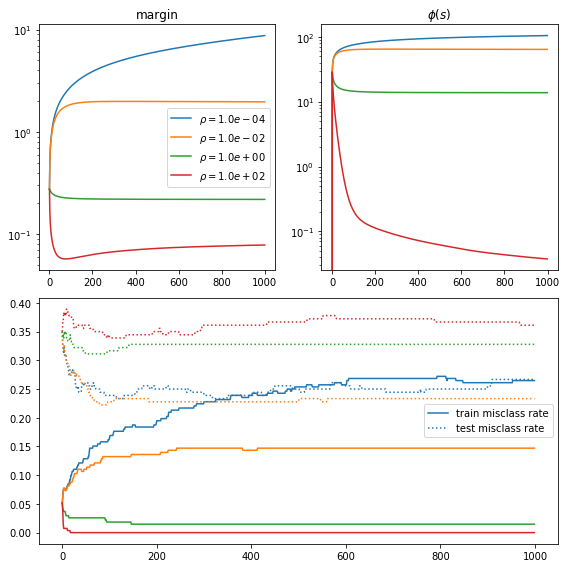

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize = (8,8))
counter = 0
for mu in [.0001,.01,1.,100.]:
    margin,infeas, misclass_train, misclass_test = run_svm(mu, maxiter=1000)
    
    plt.subplot(2,2,1)
    plt.semilogy(margin)
    plt.title('margin')
    plt.subplot(2,2,2)
    plt.semilogy(infeas)
    plt.title('$\phi(s)$')
    
    plt.subplot(2,1,2)
    plt.plot(misclass_train,color=colors[counter])
    plt.plot(misclass_test,color=colors[counter],linestyle=':')
    counter += 1
    print(margin[-1],infeas[-1], misclass_train[-1],misclass_test[-1])
    
    if mu == .01:
        best_misclass_train = misclass_train
        best_misclass_test = misclass_test
    
plt.subplot(2,2,1)
plt.legend([('$\\rho = %.1e$' % rho) for rho in [.0001,.01,1.,100.]])
plt.subplot(2,1,2)
plt.legend(['train misclass rate','test misclass rate'])
plt.tight_layout()
plt.savefig('hw2_svm.png')
plt.savefig('hw2_svm.eps')

0.5643110760002308 82.85204387580777 0.1948529411764706 0.29444444444444445
0.5798797718510339 21.632219044385337 0.27205882352941174 0.4388888888888889
0.57275553572211 37.95952546797038 0.19852941176470587 0.35


/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

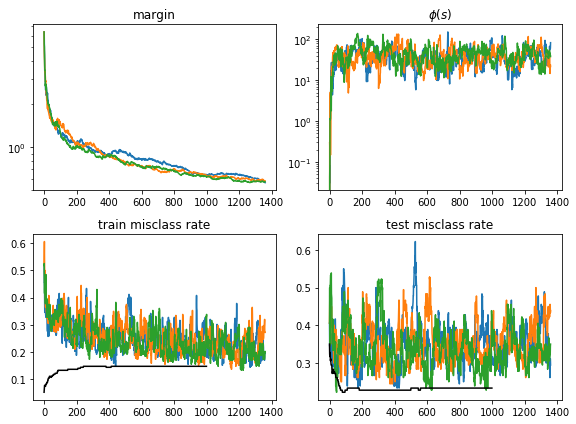

In [18]:


def proj_hyp(theta,z, target):
    return (target-np.dot(z,theta))/np.dot(z,z) * z + theta

def get_penalties(theta,target):
    margin = 1./np.sqrt(np.dot(theta,theta))
    s = target - np.dot(Z,theta)
    s = np.maximum(-s,0.)
    infeas = np.dot(s,s)/2.
    return margin,infeas
    
Z = (Xtrain.T*ytrain).T


def kaczmarz():
    theta = np.zeros(n)
    margin, infeas, misclass_train, misclass_test = [],[],[],[]
    
    idx = [1]
    for epochs in range(5):    
        idx = np.hstack([idx,np.random.permutation(m_train)])
    
    
    for i in idx:
        z = Z[i,:]
        theta = proj_hyp(theta,z, target=1.)

        mar, inf = get_penalties(theta, target=1.)
        margin.append(mar)
        infeas.append(inf)
        
        miscl_train = get_misclassify(ytrain,np.sign(np.dot(Xtrain,theta)))
        miscl_test = get_misclassify(ytest,np.sign(np.dot(Xtest,theta)))
        misclass_train.append(miscl_train)
        misclass_test.append(miscl_test)

    return np.array(margin),np.array(infeas), np.array(misclass_train), np.array(misclass_test)


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize = (8,6))
counter = 0
for trial in range(3):
    margin,infeas, misclass_train, misclass_test = kaczmarz()
    
    plt.subplot(2,2,1)
    plt.semilogy(margin)
    plt.title('margin')
    plt.subplot(2,2,2)
    plt.semilogy(infeas)
    plt.title('$\phi(s)$')
    
    plt.subplot(2,2,3)
    plt.plot(misclass_train)
    plt.title('train misclass rate')
    plt.subplot(2,2,4)
    plt.plot(misclass_test)
    plt.title('test misclass rate')

    print(margin[-1],infeas[-1], misclass_train[-1],misclass_test[-1])
    
plt.subplot(2,2,3)
plt.plot(best_misclass_train,'k')
plt.title('train misclass rate')
plt.subplot(2,2,4)
plt.plot(best_misclass_test,'k')
plt.title('test misclass rate')
    
plt.tight_layout()
plt.savefig('hw2_kaczmarz.png')
plt.savefig('hw2_kaczmarz.eps')
